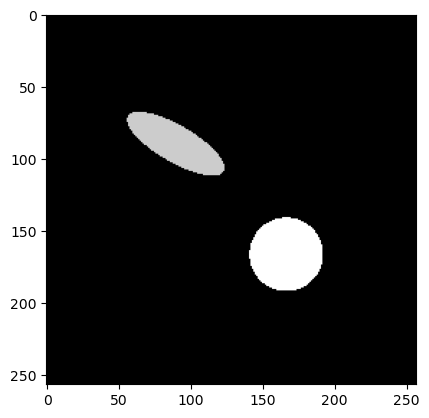

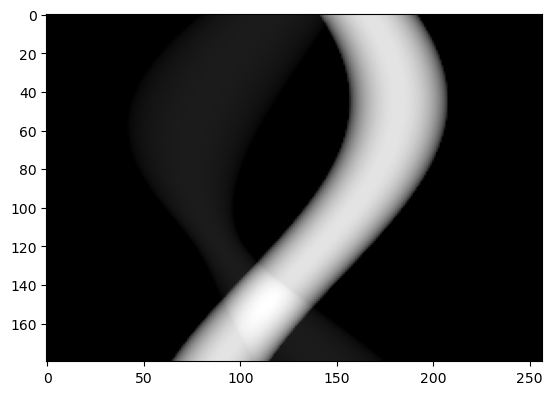

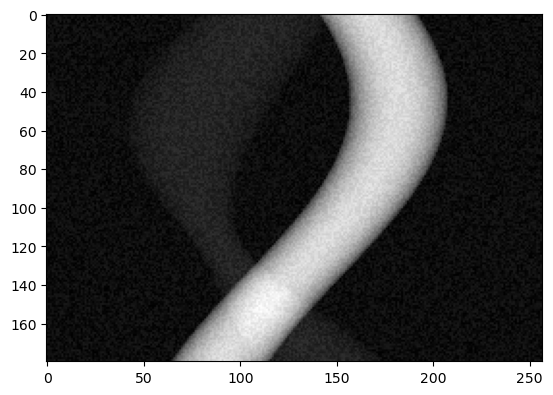

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def init_objects():
    # Initialize circle parameters
    # Each row: [radius, center_x, center_y, gray_value]
    circle_objects = np.array([
        [0.2, 0.3, 0.3, 1.0]
    ])
    
    # Initialize ellipse parameters (optional)
    # Each row: [semi-major, semi-minor, center_x, center_y, angle, gray_value]
    ellipse_objects = np.array([
        [0.3, 0.1, -0.3, -0.3, np.pi/6, 0.8]
    ])
    
    return circle_objects, ellipse_objects

def create_phantom(circle_objects=None, ellipse_objects = None, res = 5):
    # Create a phantom image based on given objects
    phantom = np.zeros((2*res+1, 2*res+1))

    if circle_objects is not None:
        for params in circle_objects:
            phantom += phantom_circle(params, res)
    if ellipse_objects is not None:
        for params in ellipse_objects:
            phantom += phantom_ellipse(params, res)

    if np.sum(phantom)<1:
        print('Warning: object lists are empty.')

    return phantom

def phantom_circle(parameters, res):
    radius, center_x, center_y, gray_value = parameters
    x = np.linspace(-1, 1, 2*res+1)
    y = np.linspace(-1, 1, 2*res+1)
    xv, yv = np.meshgrid(x, y)
    mask = (xv - center_x)**2 + (yv - center_y)**2 <= radius**2
    return gray_value * mask

def phantom_ellipse(parameters, res):
    semi_major, semi_minor, center_x, center_y, angle, gray_value = parameters
    x = np.linspace(-1, 1, 2*res+1)
    y = np.linspace(-1, 1, 2*res+1)
    xv, yv = np.meshgrid(x, y)
    mask = ((xv - center_x) * np.cos(angle) + (yv - center_y) * np.sin(angle))**2 / semi_major**2 + ((xv - center_x) * np.sin(angle) - (yv - center_y) * np.cos(angle))**2 / semi_minor**2 <= 1
    return gray_value * mask

def generate_measured_data(p, q, circle_objects=None, ellipse_objects=None):
    if circle_objects is not None and ellipse_objects is not None:
        delta_phi = np.pi / p
        phi = np.arange(p) * delta_phi
        s = np.linspace(-1, 1, 2*q+1)
        
        sinogram = np.zeros((p, 2*q+1))

        for i in range(p):
            omega = np.array([np.cos(phi[i]), np.sin(phi[i])]) #create omega vector
            for j in range(-q, q+1):
                sinogram[i, j+q] += calculate_radon_transform_circle(circle_objects, s[j+q], omega)
                sinogram[i, j+q] += calculate_radon_transform_ellipse(ellipse_objects, s[j+q], phi[i])
    else:
        print('Warning: object lists are empty.')
        sinogram = None
        phi = None
        s = None
    return sinogram, phi, s

def calculate_radon_transform_circle(circle_data, s, omega):
    radon_value = 0
    for circle in circle_data:
        radius, center_x, center_y, gray_value = circle
        term = radius**2 - (s - center_x * omega[0] - center_y * omega[1])**2
        if term > 0:
            projection = gray_value * np.sqrt(term) * 2 
            radon_value += projection
    return radon_value

def calculate_radon_transform_ellipse(ellipse_data, s, phi):
    radon_value = 0
    for ellipse in ellipse_data:
        semi_major, semi_minor, center_x, center_y, angle, gray_value = ellipse
        omega = np.array([np.cos(phi- angle), np.sin(phi- angle)])
        denom_square = (semi_major * omega[0]) **2 + (semi_minor * omega[1]) **2
        term = denom_square - (s - center_x * omega[0] - center_y * omega[1])**2
        if term > 0:
            projection = 2* gray_value  * semi_major * semi_minor * np.sqrt(term) / np.sqrt(denom_square)
            radon_value += projection

    return radon_value

def add_noise(sinogram, noise_level):
    noise = np.random.rand(*sinogram.shape) * noise_level
    sinogram_noisy = sinogram + noise
    return sinogram_noisy

res =128
p = 180
q = 128
noiselevel = 0.05
# Initialize objects
circle_objects, ellipse_objects = init_objects()

# Create phantom
phantom = create_phantom(circle_objects, ellipse_objects, res)  # Assuming resolution 128

fig, ax = plt.subplots()
ax.imshow(phantom, cmap='gray')

# Generate measured data
sinogram, phi, s = generate_measured_data(p, q, circle_objects, ellipse_objects)  # Example values for p and q

fig, ax = plt.subplots()
ax.imshow(sinogram, cmap='gray')

# Add noise
sinogram_noisy = add_noise(sinogram, noiselevel)  # Example noise level
fig, ax = plt.subplots()
ax.imshow(sinogram_noisy, cmap='gray')
